In [676]:
import os
import sys
import numpy as np
import sympy as sp
from scipy.linalg import expm
import matplotlib.pyplot as plt
os.getcwd()

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Add the parent directory to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Now you can import the module as if it were in the current directory
import IkeNMRFunc as INMR

In [976]:
# Define spin of system
I = 3/2
# Define Pauli basis
Ix,Iy,Iz,Iplus,Iminus = INMR.PauliMatrices(I)

#       y
#      ___
# RF  |   |   acq
#    _|   |________________________________________________
#     0   1   
######################################
# SYSTEM PROPERTIES

# Spin temperature
T_sp_0 = 0.0001
B_0 = 4.7

# quadrupolar splitting
ν_Q = 500
ω_Q= ν_Q*2*np.pi

# Define FID specifications
N = 2**10
dwell = 5*10**-6
ν_offset = 5000
ω_offset= ν_offset*2*np.pi
T2 = 2*10**-3

arr_time = np.linspace(0,N-1,N)*dwell
ZeroFill_factor = 3

arr_time_zfill = np.linspace(0,N*2**ZeroFill_factor-1,N*2**ZeroFill_factor)*dwell

# constants
k_B = 1.380649*10**-23
hbar = 1.054571817*10**-34
h = hbar*2*np.pi #

γ_1H = 2.6752218708*10**8 # Mrad/s
ω_1H = -γ_1H*B_0
ν_1H = ω_1H/2/np.pi

γ_75As = 4.596163*10**7  # Mrad/s
ω_75As = -γ_75As*B_0
ν_75As = ω_75As/2/np.pi

H_Z = ω_75As*Iz

rho_32,rho_12,rho_m12, rho_m32 = sp.symbols('rho_32 rho_12 rho_-12 rho_-32')
rho_0sym = sp.Matrix(([rho_32,0,0,0],
                   [0, rho_12,0,0], 
                   [0, 0, rho_m12, 0],
                   [0, 0, 0, rho_m32]
                   ))

rho_0 = expm(-hbar*H_Z/k_B/T_sp_0)/np.trace(expm(-hbar*H_Z/k_B/T_sp_0))
rho_0 = rho_0sym

values = {rho_32: 1, rho_12:0, rho_m12:0, rho_m32:0}
rho_0 = np.array(rho_0.subs(values)).astype(complex)

In [1007]:
R_RF_1 = INMR.Wig(3/2,np.pi/2,'y')
rho1 = INMR.LVN(R_RF_1, rho_0)

In [1008]:
rho1

array([[0.125     +1.58581831e-17j, 0.21650635+2.12459368e-17j,
        0.21650635+7.84102315e-18j, 0.125     +1.22663473e-17j],
       [0.21650635+1.04704294e-17j, 0.375     +7.35980840e-18j,
        0.375     -1.58581831e-17j, 0.21650635+4.24918736e-18j],
       [0.21650635+1.04704294e-17j, 0.375     +7.35980840e-18j,
        0.375     -1.58581831e-17j, 0.21650635+4.24918736e-18j],
       [0.125     -3.76797261e-18j, 0.21650635-1.27475621e-17j,
        0.21650635-2.61524757e-17j, 0.125     -7.35980840e-18j]])

In [1009]:
H_offset = ω_offset*Iz
H_Q = ω_Q*Iz*Iz
H_FID = H_offset+H_Q

FID = np.empty((N),dtype = complex)
FID_zf = np.zeros((N*2**ZeroFill_factor),dtype = complex)
for nn in range(N):
    R_fid = expm(-1j*H_FID*arr_time[nn])
    rhofid = INMR.LVN(R_fid,rho1)
    FID[nn] = np.trace(np.matmul(rhofid,Iplus))*np.exp(-arr_time[nn]**2/T2**2)
    FID_zf[nn] = FID[nn]


In [1010]:
np.exp(-arr_time[nn]**2/T2**2)

0.0014433243495290333

In [1011]:
T2

0.002

In [1012]:
np.trace(np.matmul(rhofid,Iplus))

(-1.169520285821279-0.595900349325925j)

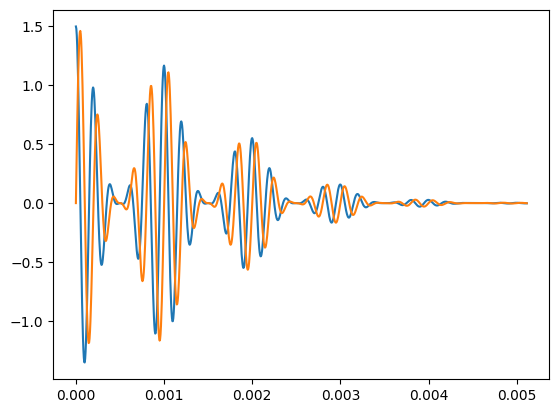

In [1013]:
plt.plot(arr_time,FID.real)
plt.plot(arr_time,FID.imag)

In [1014]:
np.fft.fftshift(FID_zf)

array([0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j])

In [1015]:
frequencies = np.fft.fftshift(np.fft.fftfreq((N*2**ZeroFill_factor),dwell))
frequencies

array([-100000.       ,  -99975.5859375,  -99951.171875 , ...,
         99926.7578125,   99951.171875 ,   99975.5859375])

(2500.0, 7500.0)

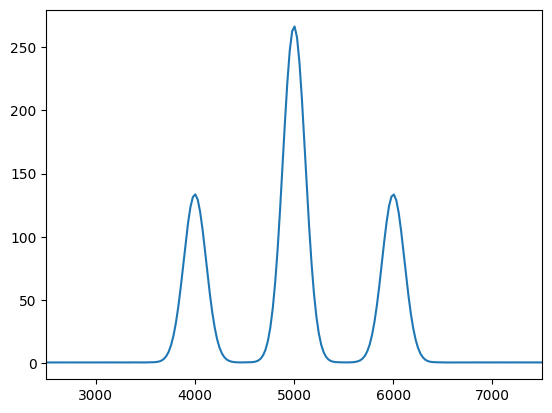

In [1016]:
plt.plot(frequencies,np.fft.fftshift(np.fft.fft(FID_zf)))
plt.xlim([2500,7500])

In [614]:
import importlib
importlib.reload(INMR)
theta = sp.symbols('theta')
Rot_plusY= INMR.Wig_sym(I,theta,'y')
Rot_plusX = INMR.Wig_sym(I,theta,'x')

# import math
# theta = sp.symbols('theta')

Matrix([[-sqrt(2)/2 + sqrt(2)*I/2, 0, 0, 0], [0, sqrt(2)/2 + sqrt(2)*I/2, 0, 0], [0, 0, sqrt(2)/2 - sqrt(2)*I/2, 0], [0, 0, 0, -sqrt(2)/2 - sqrt(2)*I/2]])
Matrix([[(-0.707106781186547 - 0.707106781186548*I)*(-0.707106781186547 + 0.707106781186548*I)*cos(theta/2)**3.0, -1.0*sqrt(3)*(-0.707106781186547 - 0.707106781186548*I)*(-0.707106781186547 + 0.707106781186548*I)*sin(theta/2)**1.0*cos(theta/2)**2.0, 1.0*sqrt(3)*(-0.707106781186547 - 0.707106781186548*I)*(-0.707106781186547 + 0.707106781186548*I)*sin(theta/2)**2.0*cos(theta/2)**1.0, (-0.707106781186547 - 0.707106781186548*I)*(0.707106781186547 - 0.707106781186548*I)*sin(theta/2)**3.0], [1.0*sqrt(3)*(0.707106781186548 - 0.707106781186548*I)*(0.707106781186548 + 0.707106781186548*I)*sin(theta/2)**1.0*cos(theta/2)**2.0, (-1.4142135623731 - 1.4142135623731*I)*(0.707106781186548 - 0.707106781186548*I)*sin(theta/2)**2.0*cos(theta/2)**1.0 + (0.707106781186548 - 0.707106781186548*I)*(0.707106781186548 + 0.707106781186548*I)*cos(theta/2)**3.0,

In [605]:
rho_32,rho_12,rho_m12, rho_m32 = sp.symbols('rho_32 rho_12 rho_-12 rho_-32')
rho_0sym = sp.Matrix(([rho_32,0,0,0],
                   [0, rho_12,0,0], 
                   [0, 0, rho_m12, 0],
                   [0, 0, 0, rho_m32]
                   ))

In [ ]:
# Positive pi/2 rotation about the +y direction should end up as a positive real number if P = + (positive gamma)
values = {theta: np.pi/2, rho_32: 1, rho_12:0, rho_m12:0, rho_m32:0}

Rot = np.array(Rot_plusY.subs(values)).astype(complex)
rho_0symrep = np.array(rho_0sym.subs(values)).astype(complex)

np.trace(np.matmul(INMR.LVN(Rot,rho_0symrep),Iplus))

(1.4999999999999998+0j)

In [666]:
# Positive pi/2 rotation about the +x direction should end up as a negative imaginary number if P = + (positive gamma)
values = {theta: np.pi/2, rho_32: 1, rho_12:0, rho_m12:0, rho_m32:0}
Rot = np.array(Rot_plusX.subs(values)).astype(complex)
rho_0symrep = np.array(rho_0sym.subs(values)).astype(complex)

np.trace(np.matmul(INMR.LVN(Rot,rho_0symrep),Iplus))

-1.4999999999999998j

In [713]:
simp_vectorized = np.vectorize(sp.nsimplify)

Iplus_p32_p12 = sp.matrices.Matrix(np.zeros((4,4)))
Iplus_p12_m12 = sp.matrices.Matrix(np.zeros((4,4)))
Iplus_m12_m32 = sp.matrices.Matrix(np.zeros((4,4)))

Iplus_p32_p12[0,1] = Iplus[0,1]
Iplus_p12_m12[1,2] = Iplus[1,2]
Iplus_m12_m32[2,3] = Iplus[2,3]

Iplus_p32_p12 = sp.matrices.immutable.ImmutableDenseMatrix(simp_vectorized(Iplus_p32_p12))
Iplus_p12_m12 = sp.matrices.immutable.ImmutableDenseMatrix(simp_vectorized(Iplus_p12_m12))
Iplus_m12_m32 = sp.matrices.immutable.ImmutableDenseMatrix(simp_vectorized(Iplus_m12_m32))

In [716]:
Iplus_p32_p12
Iplus_p12_m12
Iplus_m12_m32

Matrix([
[0, 0, 0,       0],
[0, 0, 0,       0],
[0, 0, 0, sqrt(3)],
[0, 0, 0,       0]])

In [672]:
INMR.Wig(3/2,np.pi/2,'y')

array([[ 0.35355339+2.77555756e-17j, -0.61237244+0.00000000e+00j,
         0.61237244-5.55111512e-17j, -0.35355339-2.77555756e-17j],
       [ 0.61237244+0.00000000e+00j, -0.35355339+0.00000000e+00j,
        -0.35355339+0.00000000e+00j,  0.61237244+0.00000000e+00j],
       [ 0.61237244+0.00000000e+00j,  0.35355339+0.00000000e+00j,
        -0.35355339+0.00000000e+00j, -0.61237244+0.00000000e+00j],
       [ 0.35355339-2.77555756e-17j,  0.61237244+5.55111512e-17j,
         0.61237244+0.00000000e+00j,  0.35355339-2.77555756e-17j]])

In [950]:
N = 10000
nn_list = np.linspace(0,N,N+1).astype(int)
phi_list = nn_list*2*np.pi/N
x_cent = np.empty(len(phi_list))

# sin_ex = np.sin(phi_list)
y_sat1 = 3*np.sin(phi_list)*np.sin(phi_list/2)**4
y_cent = 3/2*np.sin(phi_list)**3
y_sat2 = 3*np.sin(phi_list)*np.cos(phi_list/2)**4

In [951]:
phi_list

array([0.00000000e+00, 6.28318531e-04, 1.25663706e-03, ...,
       6.28192867e+00, 6.28255699e+00, 6.28318531e+00])

In [952]:
r_cent = 3/2/(np.cos(phi_list)**(2/3) + np.sin(phi_list)**(2/3))**(3/2)

C:\Users\Michael\AppData\Local\Temp\ipykernel_3064\3245911197.py:1: RuntimeWarning: invalid value encountered in power
  r_cent = 3/2/(np.cos(phi_list)**(2/3) + np.sin(phi_list)**(2/3))**(3/2)


In [966]:
x_sat1 = y_sat1/np.tan(phi_list)
x_cent = y_cent/np.tan(phi_list)
x_sat2 = y_sat2/np.tan(phi_list)


C:\Users\Michael\AppData\Local\Temp\ipykernel_3064\2186212186.py:1: RuntimeWarning: invalid value encountered in divide
  x_sat1 = y_sat1/np.tan(phi_list)
C:\Users\Michael\AppData\Local\Temp\ipykernel_3064\2186212186.py:2: RuntimeWarning: invalid value encountered in divide
  x_cent = y_cent/np.tan(phi_list)
C:\Users\Michael\AppData\Local\Temp\ipykernel_3064\2186212186.py:3: RuntimeWarning: invalid value encountered in divide
  x_sat2 = y_sat2/np.tan(phi_list)


In [967]:
x_ast = 3/2*np.cos(phi_list)**3
y_ast = 3/2*np.sin(phi_list)**3


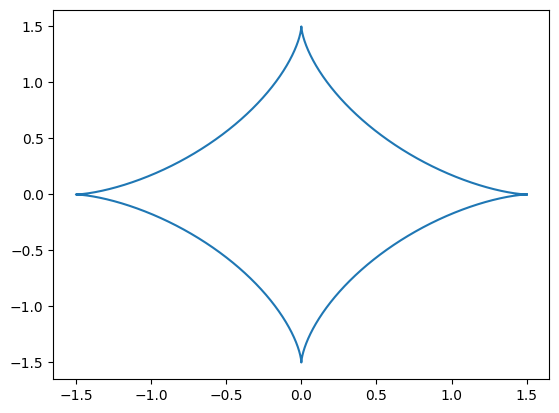

In [968]:
plt.plot(x_ast,y_ast)

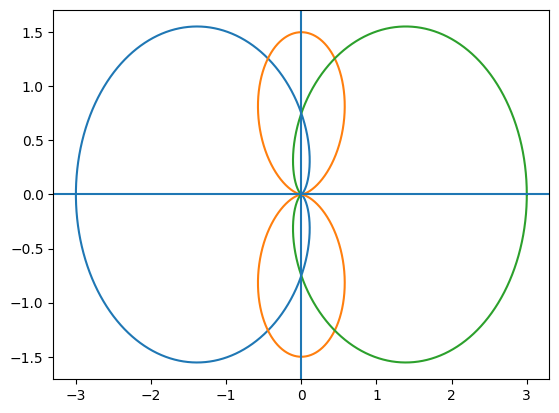

In [970]:
plt.plot(x_sat1,y_sat1)
plt.plot(x_cent,y_cent)
plt.plot(x_sat2,y_sat2)
plt.axhline()
plt.axvline()